In [40]:
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import sys
sys.path.append(r'C:\Users\tacuevas\Documents\GitHub\concorde\modules')
sys.path.append(r'C:\Users\tacuevas\Documents\GitHub\Kalpana\module')
from plots import scatter_interpolate
from tools import curvature
from kalpanaExport import pointsInsidePoly
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Polygon, Point, LineString
import dask
from tqdm.dask import TqdmCallback
import itertools
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 16})
from matplotlib.offsetbox import AnchoredText
from pyproj import Geod
pd.set_option('display.max_rows', 100)
import numpy as np

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

###### Select in and out Storms

In [3]:
# df = pd.read_pickle(r'T:\Projects\2016-2020-DHS-CRCoE\Tomas\Thesis\data\STORM\processed\STORM_NA_R3.pkl')
df = pd.read_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4.pkl')

In [4]:
df.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land,tc_number,dist_to_NC,trajectory,forwardSpeed
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,0,4336.133140,281.309932,18.695934
1,0.0,10.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429,0,4290.629311,278.130102,18.695934
2,0.0,10.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506,0,4230.498007,276.340192,25.916882
3,0.0,10.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651,0,4156.153101,275.710593,33.179142
4,0.0,10.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285,0,4075.371766,281.309932,36.812210


In [5]:
nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

In [6]:
pointsInside = pointsInsidePoly(list(zip(df['lon'].values, df['lat'].values)), list(box.geometry[0].boundary.coords))

In [7]:
df['in_instant'] = np.multiply(pointsInside, 1)

In [8]:
df.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land,tc_number,dist_to_NC,trajectory,forwardSpeed,in_instant
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,0,4336.133140,281.309932,18.695934,0
1,0.0,10.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429,0,4290.629311,278.130102,18.695934,0
2,0.0,10.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506,0,4230.498007,276.340192,25.916882,0
3,0.0,10.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651,0,4156.153101,275.710593,33.179142,0
4,0.0,10.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285,0,4075.371766,281.309932,36.812210,0


In [9]:
@dask.delayed
def splitStorms(df, i):
    dfsub = df[df.tc_number == i]
    
    ## out
    if len(dfsub['in_instant']) == 0:
        a = [0]*len(dfsub)
    ## possible in
    else:
        ## out: track last less than 24 hrs and only one timestep is inside ROI
        if len(dfsub) < 8 or len(dfsub[dfsub['in_instant'] == 1]) < 3:
            a = [0]*len(dfsub)
        ## in
        else:
            a = [1]*len(dfsub)
    
    return a

tasks = [splitStorms(df, i) for i in df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

auxMerged = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxMerged))

df['in_all'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [12]:
len(df[df['in_all'] == 1]['tc_number'].unique())

9901

In [13]:
df.isna().sum()

year                 0
month                0
yr_tc_number         0
time_step            0
basin_id             0
lat                  0
lon                  0
min_press            0
max_ws               0
rad_to_max_ws        0
cat                  0
landfall             0
dist_to_land         0
tc_number            0
dist_to_NC           0
trajectory           0
forwardSpeed         0
in_instant           0
in_all               0
in_roi_trajectory    0
dtype: int64

In [14]:
@dask.delayed
def attackTrajectory(df, i):
    dfsub = df[df.tc_number == i]
    
    if dfsub['in_all'].unique() == 0:
        val = 0
    else:
        indIn = list(dfsub['in_instant']).index(1)
        val = dfsub.loc[dfsub.index[indIn], 'trajectory']

    return [val]*len(dfsub)

tasks = [attackTrajectory(df, i) for i in df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

auxMerged = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxMerged))

df['in_roi_trajectory'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [15]:
df.head()

,year,month,yr_tc_number,time_step,basin_id,lat,lon,min_press,max_ws,rad_to_max_ws,cat,landfall,dist_to_land,tc_number,dist_to_NC,trajectory,forwardSpeed,in_instant,in_all,in_roi_trajectory
0,0.0,10.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,0,4336.133140,281.309932,18.695934,0,0,0.0
1,0.0,10.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429,0,4290.629311,278.130102,18.695934,0,0,0.0
2,0.0,10.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506,0,4230.498007,276.340192,25.916882,0,0,0.0
3,0.0,10.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651,0,4156.153101,275.710593,33.179142,0,0,0.0
4,0.0,10.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285,0,4075.371766,281.309932,36.812210,0,0,0.0


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,3507558.0,5013.666981,2883.095758,0.000000e+00,2516.000000,5023.000000,7519.000000,9999.000000
month,3507558.0,8.501050,1.152267,6.000000e+00,8.000000,9.000000,9.000000,11.000000
yr_tc_number,3507558.0,5.387186,3.854266,0.000000e+00,2.000000,5.000000,8.000000,24.000000
time_step,3507558.0,30.418734,29.024408,0.000000e+00,8.000000,22.000000,45.000000,298.000000
basin_id,3507558.0,1.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
lat,3507558.0,24.060422,10.487971,5.100000e+00,15.600000,22.200000,30.600000,59.900000
lon,3507558.0,-56.092493,18.358782,-1.049000e+02,-68.600000,-56.100000,-43.000000,-1.100000
min_press,3507558.0,976.355539,19.766938,8.834000e+02,964.800000,981.400000,992.100000,1016.600000
max_ws,3507558.0,32.859786,12.039700,3.663698e+00,22.800000,30.400000,40.900000,83.502870
rad_to_max_ws,3507558.0,48.397782,24.374266,9.260000e+00,33.099575,44.384137,55.814197,444.480011


In [17]:
df.isna().sum()

year                 0
month                0
yr_tc_number         0
time_step            0
basin_id             0
lat                  0
lon                  0
min_press            0
max_ws               0
rad_to_max_ws        0
cat                  0
landfall             0
dist_to_land         0
tc_number            0
dist_to_NC           0
trajectory           0
forwardSpeed         0
in_instant           0
in_all               0
in_roi_trajectory    0
dtype: int64

In [18]:
@dask.delayed
def meanTrajectory(df, i):
    dfsub = df[df.tc_number == i]
    
    if dfsub['in_all'].unique() == 0:
        val = 0
    
    else:
        indIn = dfsub[dfsub['in_instant'] == 1].index
        xs = [np.cos(np.deg2rad(a)) for a in dfsub.loc[indIn, 'trajectory']]
        ys = [np.sin(np.deg2rad(a)) for a in dfsub.loc[indIn, 'trajectory']]
        val = np.mod(np.rad2deg(np.arctan2(np.mean(ys), np.mean(xs))), 360)
    
    return [val]*len(dfsub)

tasks = [meanTrajectory(df, i) for i in df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

auxMerged = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxMerged))

df['in_mean_trajectory'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,3507558.0,5013.666981,2883.095758,0.000000e+00,2516.000000,5023.000000,7519.000000,9999.000000
month,3507558.0,8.501050,1.152267,6.000000e+00,8.000000,9.000000,9.000000,11.000000
yr_tc_number,3507558.0,5.387186,3.854266,0.000000e+00,2.000000,5.000000,8.000000,24.000000
time_step,3507558.0,30.418734,29.024408,0.000000e+00,8.000000,22.000000,45.000000,298.000000
basin_id,3507558.0,1.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
lat,3507558.0,24.060422,10.487971,5.100000e+00,15.600000,22.200000,30.600000,59.900000
lon,3507558.0,-56.092493,18.358782,-1.049000e+02,-68.600000,-56.100000,-43.000000,-1.100000
min_press,3507558.0,976.355539,19.766938,8.834000e+02,964.800000,981.400000,992.100000,1016.600000
max_ws,3507558.0,32.859786,12.039700,3.663698e+00,22.800000,30.400000,40.900000,83.502870
rad_to_max_ws,3507558.0,48.397782,24.374266,9.260000e+00,33.099575,44.384137,55.814197,444.480011


In [20]:
df.isna().sum()

year                  0
month                 0
yr_tc_number          0
time_step             0
basin_id              0
lat                   0
lon                   0
min_press             0
max_ws                0
rad_to_max_ws         0
cat                   0
landfall              0
dist_to_land          0
tc_number             0
dist_to_NC            0
trajectory            0
forwardSpeed          0
in_instant            0
in_all                0
in_roi_trajectory     0
in_mean_trajectory    0
dtype: int64

In [21]:
@dask.delayed
def curvature_parallel(df, i):
    dfsub = df[df.tc_number == i]
    
    if dfsub['in_all'].unique() == 0:
        val = 0
    else:
        dfsub2 = dfsub[dfsub['in_instant'] == 1]
        cur = curvature(dfsub2['lon'].values, dfsub2['lat'].values)
        val = np.nanmean(cur)
    
    return [val]*len(dfsub)

tasks = [curvature_parallel(df, i) for i in df.tc_number.unique()]

with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

auxMerged = list(itertools.chain(*aux))
auxM = list(itertools.chain(*auxMerged))

df['in_curvature'] = auxM

Computing distance:   0%|          | 0/109479 [00:00<?, ?it/s]

In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,3507558.0,5013.666981,2883.095758,0.000000e+00,2516.000000,5023.000000,7519.000000,9999.000000
month,3507558.0,8.501050,1.152267,6.000000e+00,8.000000,9.000000,9.000000,11.000000
yr_tc_number,3507558.0,5.387186,3.854266,0.000000e+00,2.000000,5.000000,8.000000,24.000000
time_step,3507558.0,30.418734,29.024408,0.000000e+00,8.000000,22.000000,45.000000,298.000000
basin_id,3507558.0,1.000000,0.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
lat,3507558.0,24.060422,10.487971,5.100000e+00,15.600000,22.200000,30.600000,59.900000
lon,3507558.0,-56.092493,18.358782,-1.049000e+02,-68.600000,-56.100000,-43.000000,-1.100000
min_press,3507558.0,976.355539,19.766938,8.834000e+02,964.800000,981.400000,992.100000,1016.600000
max_ws,3507558.0,32.859786,12.039700,3.663698e+00,22.800000,30.400000,40.900000,83.502870
rad_to_max_ws,3507558.0,48.397782,24.374266,9.260000e+00,33.099575,44.384137,55.814197,444.480011


In [23]:
df.isna().sum()

year                  0
month                 0
yr_tc_number          0
time_step             0
basin_id              0
lat                   0
lon                   0
min_press             0
max_ws                0
rad_to_max_ws         0
cat                   0
landfall              0
dist_to_land          0
tc_number             0
dist_to_NC            0
trajectory            0
forwardSpeed          0
in_instant            0
in_all                0
in_roi_trajectory     0
in_mean_trajectory    0
in_curvature          0
dtype: int64

In [24]:
df.to_pickle(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_InOut_v6.pkl")

In [25]:
geom = []
dfin = df[df['in_all'] == 1]
for i in tqdm(dfin.tc_number.unique()):
    subdf = dfin[dfin.tc_number == i]
    lstring = LineString(list(zip(subdf.lon, subdf.lat)))
    geom.append(lstring)

gdfIn = gpd.GeoDataFrame(geometry = geom, crs = 4326)

100%|█████████████████████████████████████████████████████████████████████████████| 9901/9901 [00:10<00:00, 961.50it/s]


In [48]:
gdfIn.to_file(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6.gpkg", driver = 'GPKG')

In [45]:
geom = []
dfin = df[df['in_all'] == 0]
for i in tqdm(dfin.tc_number.unique()):
    subdf = dfin[dfin.tc_number == i]
    lstring = LineString(list(zip(subdf.lon, subdf.lat)))
    geom.append(lstring)

gdfOut = gpd.GeoDataFrame(geometry = geom, crs = 4326)

100%|███████████████████████████████████████████████████████████████████████████| 99578/99578 [09:17<00:00, 178.67it/s]


In [49]:
gdfOut.to_file(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_Out_pnt_v6.gpkg", driver = 'GPKG')

In [26]:
@dask.delayed
def track2point(df, i):
    dfsub = df[(df.tc_number == i)]
    ## fill na values of trajectory
    dfsub = dfsub.fillna(method = 'ffill')
    indMinPress = dfsub['min_press'].idxmin()
    indMinDist = dfsub['dist_to_NC'].idxmin()
        
    l = [float(dfsub.year.unique()), #year
         float(dfsub.month.unique()), #month
         float(dfsub.yr_tc_number.unique()), #yearly tc number 
         dfsub.loc[indMinPress, 'time_step'], #ts min press
         dfsub.loc[indMinDist, 'time_step'], #ts min dist
         dfsub.loc[indMinPress, 'lat'], #lat min press
         dfsub.loc[indMinPress, 'lon'], # lon min press
         dfsub.loc[indMinDist, 'lat'], #lat min dist
         dfsub.loc[indMinDist, 'lon'], #lon min dist
         dfsub.loc[indMinDist, 'min_press'], #min press at min dist
         dfsub.loc[indMinPress, 'min_press'], #min press at min press
         dfsub.loc[indMinDist, 'max_ws'], #max ws at min dist
         dfsub.loc[indMinPress, 'max_ws'], #max ws at min press
         dfsub.loc[indMinDist, 'rad_to_max_ws'], #max rmw at min dist
         dfsub.loc[indMinPress, 'rad_to_max_ws'], #max rmw at min press
         dfsub.loc[indMinDist, 'forwardSpeed'], #f speed at min dist
         dfsub.loc[indMinPress, 'forwardSpeed'], #f speed at min press
         float(dfsub.cat.max()), #max category
         float(dfsub.landfall.max()),  #categorical landfall
         float(dfsub.tc_number.unique()), #tc number
         dfsub.loc[indMinDist, 'dist_to_NC'], #min dist to NC
         dfsub.loc[indMinPress, 'dist_to_NC'], #dist NC at min press
         dfsub.loc[indMinDist, 'trajectory'], #trajectory at min dist
         dfsub.loc[indMinPress, 'trajectory'], #trajectory at min press
         float(dfsub['in_roi_trajectory'].max()), #trajectory when entering roi
         float(dfsub['in_mean_trajectory'].max()), #mean trajectory inside roi
         float(dfsub['in_curvature'].max()), #mean curvature inside roi
         len(dfsub)*3, ## from number of timesteps to hours
         dfsub.loc[dfsub.index[0], 'lat'], #lat gen
         dfsub.loc[dfsub.index[0], 'lon']] #lon gen
    return l

dfin = df[df['in_all'] == 1]
tasks = [track2point(dfin, i) for i in dfin['tc_number'].unique()]
with TqdmCallback(desc = "Computing distance"):
    aux = dask.compute(tasks, scheduler = 'threads')

Computing distance:   0%|          | 0/9901 [00:00<?, ?it/s]

In [27]:
auxMerged = list(itertools.chain(*aux))
dfpnt = pd.DataFrame(auxMerged,
                     columns = ['year', 
                                'month', 
                                'yr_tc_number', 
                                'time_step_at_min_press', 
                                'time_step_at_min_distNC',
                                'lat_at_min_press', 
                                'lon_at_min_press', 
                                'lat_at_min_distNC', 
                                'lon_at_min_distNC',
                                'min_press_at_min_distNC', 
                                'min_press_at_min_press',
                                'max_ws_at_min_distNC', 
                                'max_ws_at_min_press',
                                'rad_to_max_ws_at_min_distNC', 
                                'rad_to_max_ws_at_min_press',
                                'forward_speed_at_min_distNC', 
                                'forward_speed_at_min_press',
                                'max_cat', 
                                'landfall', 
                                'tc_number', 
                                'distNC_at_min_distNC', 
                                'distNC_at_min_press',
                                'trajectory_at_min_distNC', 
                                'trajectory_at_min_press', 
                                'trajectory_in_roi',
                                'mean_trajectory_roi',
                                'mean_curvature_roi', 
                                'duration', 
                                'lat_gen', 
                                'lon_gen'])

geod = Geod(ellps="WGS84")
dfpnt['length'] = [geod.geometry_length(x)/1_000 for x in gdfIn.geometry]

In [28]:
dfpnt.describe().T

,count,mean,std,min,25%,50%,75%,max
year,9901.0,4974.780224,2890.625825,0.000000e+00,2490.000000,4947.000000,7497.000000,9999.000000
month,9901.0,8.488234,1.195187,6.000000e+00,8.000000,9.000000,9.000000,11.000000
yr_tc_number,9901.0,5.295930,3.851052,0.000000e+00,2.000000,5.000000,8.000000,22.000000
time_step_at_min_press,9901.0,21.319059,18.600063,2.000000e+00,8.000000,16.000000,29.000000,188.000000
time_step_at_min_distNC,9901.0,27.906676,27.590750,0.000000e+00,8.000000,17.000000,43.000000,234.000000
lat_at_min_press,9901.0,30.458863,6.853773,8.300000e+00,27.500000,31.300000,34.300000,59.900000
lon_at_min_press,9901.0,-69.921957,11.393619,-9.860000e+01,-76.700000,-73.200000,-67.300000,-1.200000
lat_at_min_distNC,9901.0,33.982224,1.824517,2.930000e+01,32.700000,34.300000,35.200000,40.100000
lon_at_min_distNC,9901.0,-75.827169,2.549720,-8.290000e+01,-77.600000,-75.600000,-73.900000,-70.800000
min_press_at_min_distNC,9901.0,982.083775,19.255035,9.035000e+02,970.800000,988.000000,997.400000,1010.400000


In [50]:
dfpnt.to_pickle(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v6.pkl")

In [37]:
for col in dfpnt.columns:
    gdfIn[col] = dfpnt[col].values

In [39]:
gdfIn.to_file(r"C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_IN_v6.gpkg")

##### Plots

Text(0.5, 1.0, 'Closest point to NC of each storm in the STORM dataset')

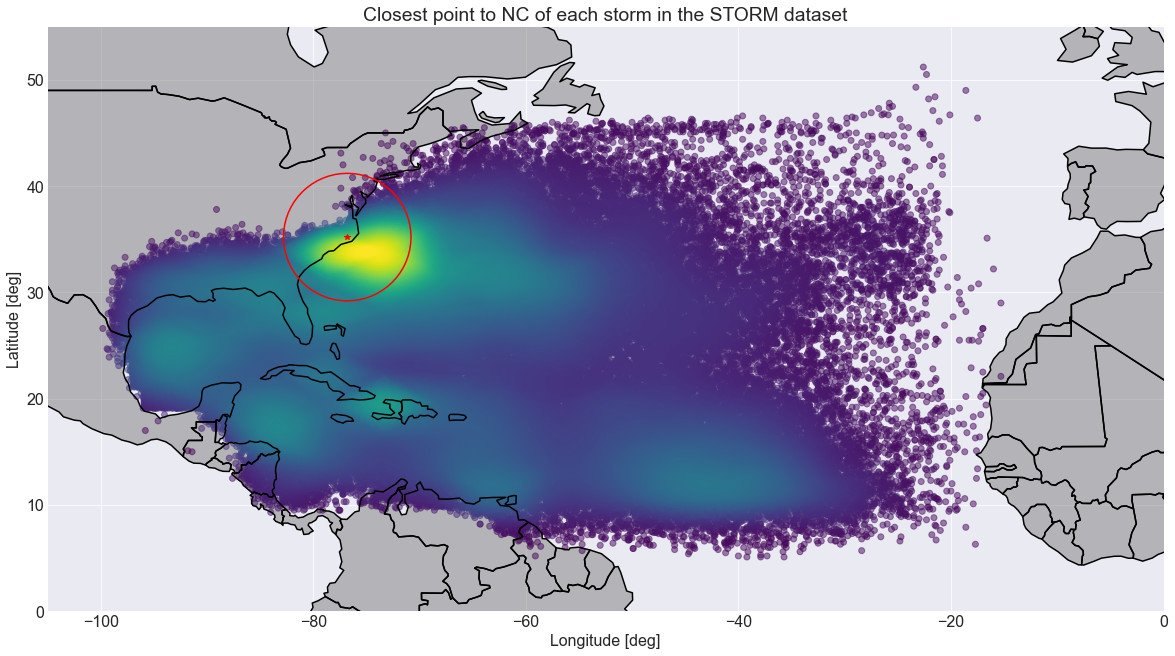

In [55]:
a = df.groupby('tc_number')['dist_to_NC'].idxmin()
dfNC = df.loc[a, :]

x = dfNC.loc[:, 'lon'].values
y = dfNC.loc[:, 'lat'].values
z = scatter_interpolate(x,y)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cm = plt.cm.get_cmap('viridis')
fig, ax = plt.subplots(figsize = (20, 20))

dfworld.plot(ax = ax, color = 'grey', alpha = 0.5)
dfworld.boundary.plot(ax = ax, color = 'k')
ax.scatter(x, y, c = z, cmap = cm, alpha = 0.5)
box.boundary.plot(ax = ax, color = 'r')
ax.plot([-76.8], [35.2], color = 'r', marker = '*')
ax.set_xlim([-105, 0])
ax.set_ylim([0, 55])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Closest point to NC of each storm in the STORM dataset')

# text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
# ax.add_artist(text)

Text(0.5, 1.0, 'Genesis location of considered storms')

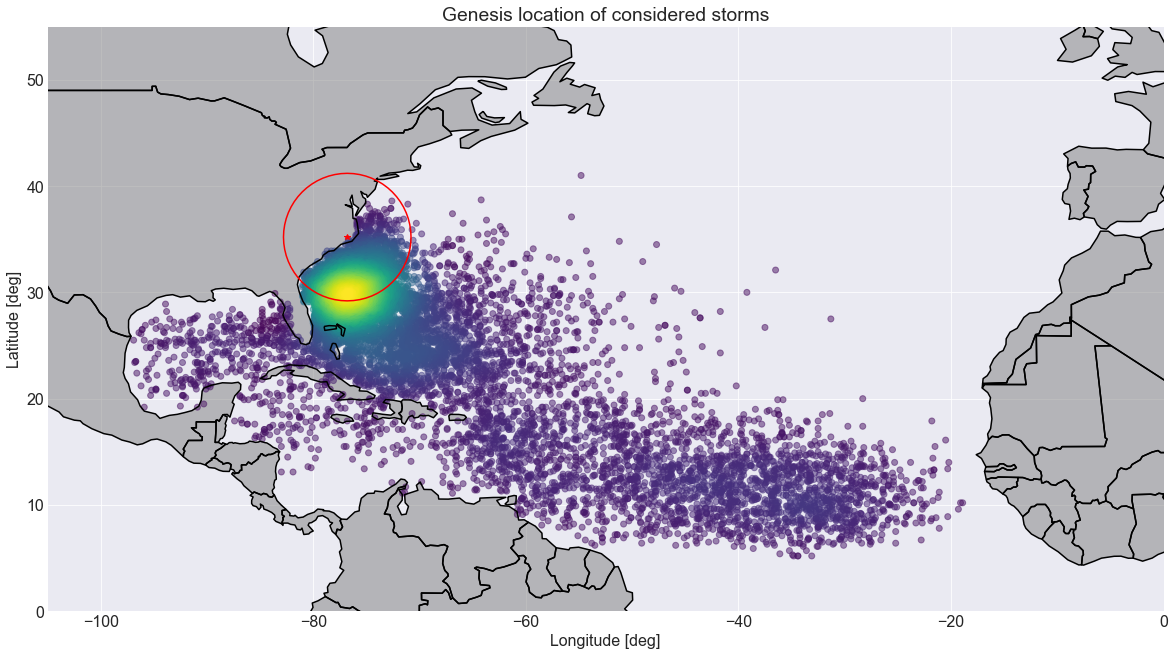

In [62]:
dfgen = df[(df.time_step == 0) & (df['in_all'] == 1)]
dfworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
x = dfgen.loc[:, 'lon'].values
y = dfgen.loc[:, 'lat'].values
z = scatter_interpolate(x,y)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
# cm = plt.cm.get_cmap('viridis')
cm = plt.cm.get_cmap('viridis')
fig, ax = plt.subplots(figsize = (20, 20))

dfworld.plot(ax = ax, color = 'grey', alpha = 0.5)
dfworld.boundary.plot(ax = ax, color = 'k')
ax.scatter(x, y, c = z, cmap = cm, alpha = 0.5)
box.boundary.plot(ax = ax, color = 'r')
ax.plot([-76.8], [35.2], color = 'r', marker = '*')
ax.set_xlim([-105, 0])
ax.set_ylim([0, 55])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Genesis location of considered storms')

# text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
# ax.add_artist(text)

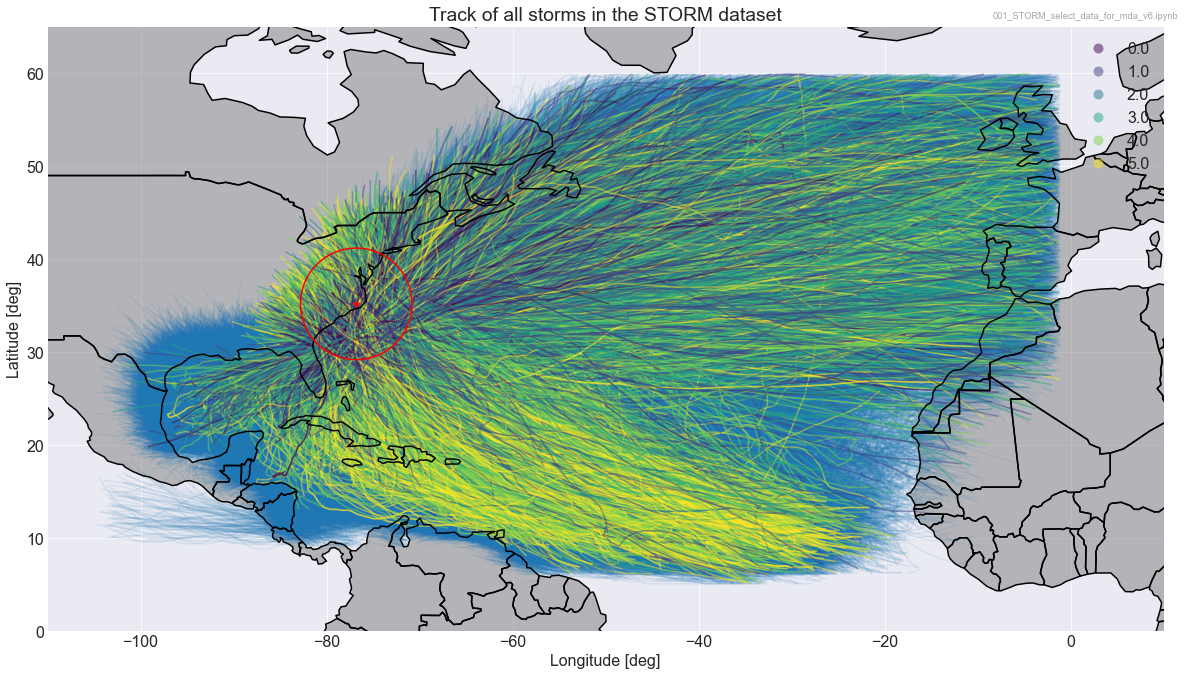

In [69]:
# gdfall = pd.concat([gdfIn, gdOout], axis = 0)
fig, ax = plt.subplots(figsize = (20, 20))
dfworld.plot(ax = ax, color = 'grey', alpha = 0.5)
gdfOut.plot(ax = ax, alpha = 0.1)
gdfIn.plot(ax = ax, alpha = 0.5, column = 'max_cat', cmap = 'viridis', legend = True, categorical = True)
dfworld.boundary.plot(ax = ax, color = 'k')
box.boundary.plot(ax = ax, color = 'r')
ax.plot([-76.8], [35.2], color = 'r', marker = '*')


ax.set_xlim([-110, 10])
ax.set_ylim([0, 65])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('Track of all storms in the STORM dataset')

leg = ax.get_legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_facecolor('w')
# leg.set_frameon(True)
# leg.set_bbox_to_anchor((1.15,0.5))

text = AnchoredText(nb_name, 'upper right', frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

Text(145.375, 0.5, 'Latitude [deg]')

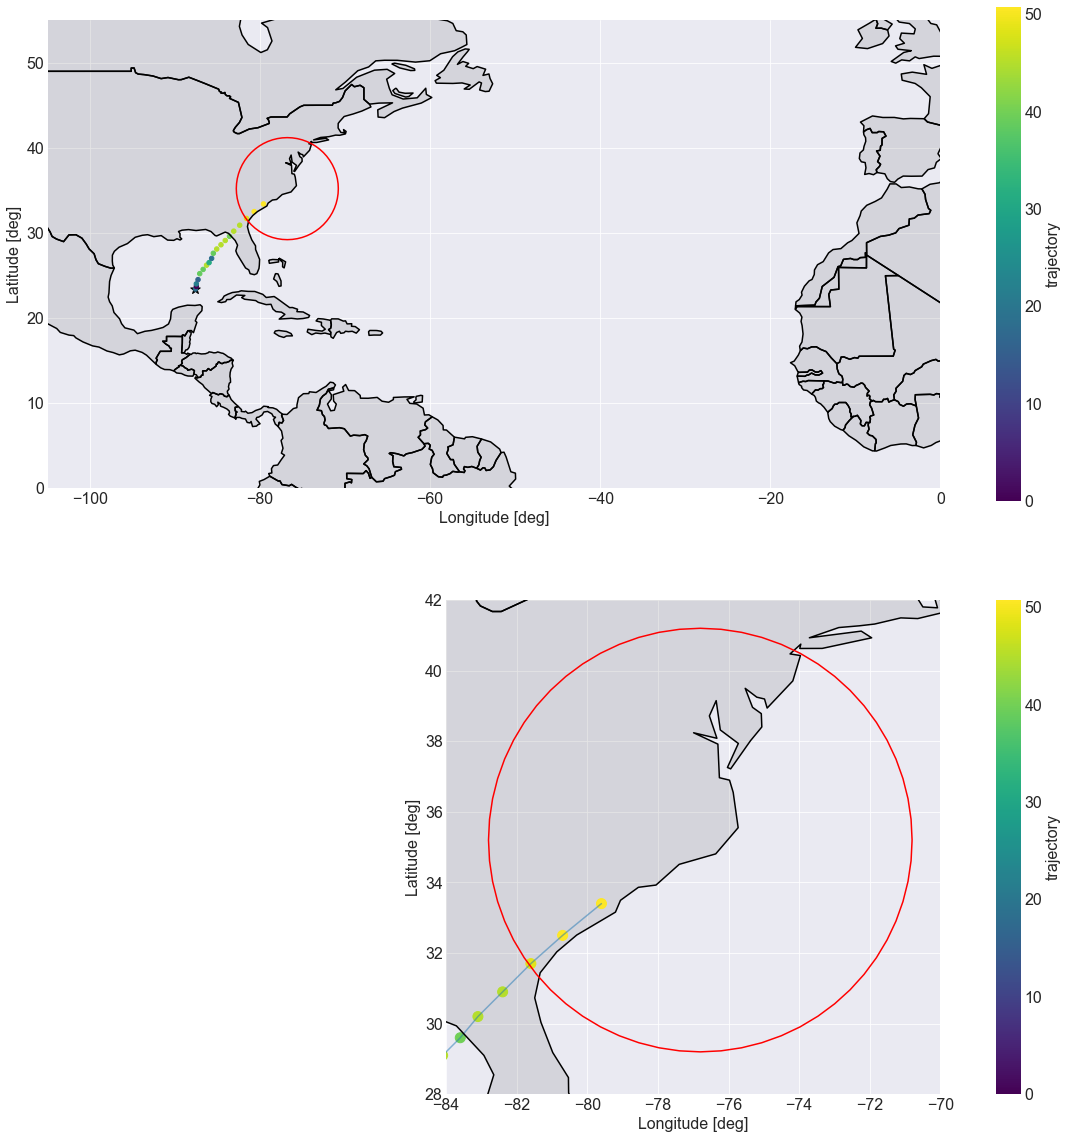

In [83]:
dfsub = df[df['tc_number'] == 1139]
dfworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
color_var = 'trajectory'

fig, ax = plt.subplots(figsize = (20, 20), nrows = 2)
dfworld.plot(ax = ax[0], color = 'grey', alpha = 0.2)
dfsub.iloc[[0], :].plot.scatter(x = 'lon', y = 'lat', ax = ax[0], marker = '*', s = 100, c = 'k')
dfsub.plot.scatter(x = 'lon', y = 'lat', ax = ax[0], c = color_var, cmap = 'viridis')
dfworld.boundary.plot(ax = ax[0], color = 'k')
box.boundary.plot(ax = ax[0], color = 'r')
ax[0].set_xlim([-105, 0])
ax[0].set_ylim([0, 55])
ax[0].set_aspect('equal')

dfworld.plot(ax = ax[1], color = 'grey', alpha = 0.2)
dfsub.iloc[[0], :].plot.scatter(x = 'lon', y = 'lat', ax = ax[1], marker = '*', s = 100, c = 'k')
dfsub.plot(x = 'lon', y = 'lat', ax = ax[1], alpha = 0.5, label = '__nolegend__', legend = False)
dfsub.plot.scatter(x = 'lon', y = 'lat', ax = ax[1], c = color_var, cmap = 'viridis', s = 100)
dfworld.boundary.plot(ax = ax[1], color = 'k')
box.boundary.plot(ax = ax[1], color = 'r')
ax[1].set_xlim([-84, -70])
ax[1].set_ylim([28, 42])
ax[1].set_aspect('equal')

ax[0].set_xlabel('Longitude [deg]')
ax[0].set_ylabel('Latitude [deg]')

ax[1].set_xlabel('Longitude [deg]')
ax[1].set_ylabel('Latitude [deg]')